# Part II: The Power of Federated Learning for Network Security

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leolavaur/icdcs_2025/blob/main/notebooks/part2.ipynb)

In this second part, we will look at FL as a solution to the problem of sharing network data to train IDSs. We will use NSL-KDD, a commonly used (and sometimes criticized) dataset for training IDSs, and a simple neural network architecture to train our model. The IDS use case involves NIID data, so we will also see how FL can be used to *share knowledge* between different institutions.

## Section 0: Prerequisites

### Dependencies

> Be advised that Google collab currently does not support the latest versions of Python (limited to 3.11.13).
> The present notebook has been designed to work with Python 3.11, and may not work with earlier or later versions.
> Please ensure that you have the correct Python version.

If you are running this notebook in Google Colab, you can install the required dependencies by running the following cell. Otherwise, you can install them in your local environment using `uv` or `pip`.


In [14]:
from IPython.core.getipython import get_ipython

if "google.colab" in str(get_ipython()):
    !pip isntall -r requirements.txt

Once you have a working environment, check that everything works, notably your GPU for the TensorFlow backend.
You can do so by running the following cell:

In [15]:
import tensorflow as tf
from IPython.utils import io

with io.capture_output(stdout=False) as _:
    print("TensorFlow version:", tf.__version__)
    print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.19.0
Num GPUs Available: 0


To allow others to reproduce your results with some degree of certitude, set a seed for all the pseudo-random number generators (PRNG) that you use.
You should also run your threads deterministically, in case your ML backend optimize training.
This will have a negative impact on the performance.
On TensorFlow: 

In [16]:
import keras


def set_seed(seed: int):
    """Set seed for reproducibility."""
    keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()


set_seed(42)

### Section 1: Data exploration and partitioning

In this section, we will explore the NSL-KDD dataset and partition it into train and test sets. We will also create a function to generate IID and NIID data partitions.

NSL-KDD is a set of network flows that have been labeled as either "normal" or one of the 22 attack clasees. The dataset is actually a modified version of the original KDD Cup 1999 dataset, which has been criticized for containing duplicate records and for not being representative of modern network traffic. NSL-KDD is a newer version of the dataset that addresses these issues. It is commonly used for training IDSs, but is still made of outdated data. For FL experiment however, it is interesting because of the amount of resources on this dataset in the literature.

In [17]:
from utils.nslkdd import load_nslkdd

dds = load_nslkdd()
dds

Dataset zip already exists.
Dataset already extracted.


DatasetDict({
    train: Dataset({
        features: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'binary_label'],
        num_rows: 125973
    })
    test: Dataset({
        features: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num

In [18]:
import pandas as pd

print(
    "Number of features:",
    len([feat for feat in dds["train"].features if "label" not in feat]),
)
print("Length of training set:", len(dds["train"]))
print("Length of test set:", len(dds["test"]))
print(
    f"Label distribution in training set: {pd.Series(dds['train']['label']).value_counts()}"
)

Number of features: 41
Length of training set: 125973
Length of test set: 22544
Label distribution in training set: 16    67343
14    41214
25     3633
7      3599
20     2931
27     2646
15     1493
1       956
32      892
34      890
19      201
4        53
2        30
35       20
8        18
6        11
23       10
9         9
3         8
12        7
18        4
17        3
30        2
Name: count, dtype: int64


To encode categorical features or labels, Hugging Face Datasets provides a `ClassLabel` feature type that replaces the string labels with integer indices.

In [19]:
ATTACK_LABELS = dds["train"].features["label"].names
print("Attack labels:", ATTACK_LABELS)

Attack labels: ['apache2', 'back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'ipsweep', 'land', 'loadmodule', 'mailbomb', 'mscan', 'multihop', 'named', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'processtable', 'ps', 'rootkit', 'saint', 'satan', 'sendmail', 'smurf', 'snmpgetattack', 'snmpguess', 'spy', 'sqlattack', 'teardrop', 'udpstorm', 'warezclient', 'warezmaster', 'worm', 'xlock', 'xsnoop', 'xterm']


In [20]:
pd.Series(dds["train"]["binary_label"]).value_counts().set_axis(["Benign", "Malicious"])

Benign       67343
Malicious    58630
Name: count, dtype: int64

## Section 2: Training on local data

In [21]:
BATCH_SIZE = 256
NUM_EPOCHS = 10
NUM_CLIENTS = 10
NUM_ROUNDS = 10

Let us prepare the data for training, namely by creating the TensorFlow dataset objects for the training and test sets, as seen in part I. 

In [22]:
def dict_to_tensor(features, label):
    # Stack all features as float32
    x = tf.stack([tf.cast(features[col], tf.float32) for col in features], axis=-1)
    return x, label


columns = [col for col in dds["train"].features if "label" not in col]
# Prepare the tf.data.Dataset for training
train_tf = (
    dds["train"]
    .to_tf_dataset(
        columns=columns, label_cols="binary_label", shuffle=True, batch_size=256
    )
    .map(dict_to_tensor)
)
test_tf = (
    dds["test"]
    .to_tf_dataset(
        columns=columns, label_cols="binary_label", shuffle=False, batch_size=256
    )
    .map(dict_to_tensor)
)


Here we use a DNN architecture with 2 hidden layers of 64 neurons each. We use the Adam optimizer with an adaptive learning rate, and the binary cross-entropy loss function. The "dropout" layers are used to prevent overfitting by randomly dropping some neurons during training.

This is a typical architecture for this use case that you can use for netflow classification tasks.

In [23]:
import keras

n_features = len([feat for feat in dds["train"].features if "label" not in feat])
print(n_features)


def mk_model() -> keras.Model:
    model = keras.models.Sequential(
        [
            keras.layers.Input(shape=(n_features,)),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"],
    )
    return model


mk_model().summary()

41


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,913 (27.00 KB)

 Trainable params: 6,913 (27.00 KB)

 Non-trainable params: 0 (0.00 B)

Since IDS are typically a NIID use case, we will also create a function to generate NIID data partitions. This function will be used later to generate the data for the FL experiment.

We will also need a more evolved evaluation method for this use case, as we want to see how well the model performs on each attack class.

In [ ]:
from typing import cast

import flwr
import numpy as np
from sklearn.metrics import confusion_matrix


def get_evaluate_fn(test_tf):
    """Return an evaluation function for server-side (i.e. centralized) evaluation."""

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: flwr.common.NDArrays,
        config: dict[str, flwr.common.Scalar],
    ):
        if server_round == NUM_ROUNDS:
            # Save final model
            np.save("fl_weights", np.array(parameters, dtype=object))

        model = mk_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, _ = model.evaluate(test_tf, verbose=cast(str, 0))

        inferences = model.predict(test_tf, verbose=cast(str, 0))
        y_pred = np.argmax(np.round(inferences), axis=1)
        y_true = np.concatenate([y.numpy() for _, y in test_tf], axis=0)

        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        return (
            loss,
            {
                "accuracy": (tn + tp) / (tn + fp + fn + tp),
                "precision": tp / (tp + fp),
                "recall": tp / (tp + fn),
                "f1": 2 * tp / (2 * tp + fp + fn),
                "miss_rate": fn / (fn + tp),
            },
        )

    return evaluate


def eval_model(parameters, test_tf):
    """Evaluate the model with the given parameters on the test dataset."""
    loss, metrics = get_evaluate_fn(test_tf)(0, parameters, {})
    return {"loss": loss} | metrics


def eval_classes(parameters, test_tf, class_array):
    """Evaluate the model with the given parameters on the test dataset, per class."""
    model = mk_model()
    model.set_weights(parameters)
    inferences = model.predict(test_tf, verbose=cast(str, 0))
    y_pred = np.argmax(np.round(inferences), axis=1)
    y_true = np.concatenate([y.numpy() for _, y in test_tf], axis=0)

    classes_stats = {}
    for cls in class_array.unique():
        class_filter = class_array == cls

        count = len(class_array[class_filter])
        if not (count > 0):
            continue
        correct = len(class_array[(class_filter) & (y_true == y_pred)])
        missed = len(class_array[(class_filter) & (y_true != y_pred)])

        classes_stats[cls] = {
            "count": count,
            "correct": correct,
            "missed": missed,
            "rate": correct / count,
        }

    ret = pd.DataFrame(classes_stats).T
    ret[["count", "correct", "missed"]].astype(int, copy=False)
    return ret

First, lets create one client with one partition of the data to simulate what one single organization might have access to. We start with IID distribution.

In [31]:
trainset, testset = load_nslkdd()

X, y, _ = partition(10, trainset)[0]
print(X.shape)
print(y.shape)

(12597, 122)
(12597, 2)


In [32]:
model = mk_model()
model.fit(X, y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

score_iid = eval_model(model.get_weights(), testset)
score_iid

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7906 - loss: 0.4458
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9628 - loss: 0.1363
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9703 - loss: 0.1147
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9710 - loss: 0.0955
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9747 - loss: 0.0805
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9745 - loss: 0.0803
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9774 - loss: 0.0699
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9770 - loss: 0.0682
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9776 - loss: 0.0638
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9793 - loss: 0.0562


{'loss': 1.2584328651428223,
 'accuracy': 0.765347764371895,
 'precision': 0.9208793661421716,
 'recall': 0.6430296890828333,
 'f1': 0.7572726438469304,
 'miss_rate': 0.3569703109171667}

In [33]:
eval_classes(model.get_weights(), testset)

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,count,correct,missed,rate
neptune,4657.0,4655.0,2.0,0.999571
normal,9711.0,9002.0,709.0,0.926990
saint,319.0,306.0,13.0,0.959248
mscan,996.0,764.0,232.0,0.767068
guess_passwd,1231.0,3.0,1228.0,0.002437
smurf,665.0,662.0,3.0,0.995489
apache2,737.0,602.0,135.0,0.816825
satan,735.0,649.0,86.0,0.882993
buffer_overflow,20.0,0.0,20.0,0.000000
back,359.0,50.0,309.0,0.139276


Now, let's train the same model architecture on a more realistic use case, where a local organization might not have access to all data.

In [34]:
X, y, _ = partition(10, trainset, n_drop=4)[0]
model = mk_model()
model.fit(X, y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
score_niid = eval_model(model.get_weights(), testset)
score_niid

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9393 - loss: 0.3267
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0068
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.2133e-04
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 4.5423e-04
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8924e-04
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2337e-04
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7243e-04
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.5277e-04
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.7429e-05


{'loss': 5.359913349151611,
 'accuracy': 0.5692423704755145,
 'precision': 0.5692423704755145,
 'recall': 1.0,
 'f1': 0.7254996183961331,
 'miss_rate': 0.0}

In [35]:
eval_classes(model.get_weights(), testset)

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,count,correct,missed,rate
neptune,4657.0,4657.0,0.0,1.0
normal,9711.0,0.0,9711.0,0.0
saint,319.0,319.0,0.0,1.0
mscan,996.0,996.0,0.0,1.0
guess_passwd,1231.0,1231.0,0.0,1.0
smurf,665.0,665.0,0.0,1.0
apache2,737.0,737.0,0.0,1.0
satan,735.0,735.0,0.0,1.0
buffer_overflow,20.0,20.0,0.0,1.0
back,359.0,359.0,0.0,1.0


## Section 3: Collaborative learning using FL

As in part I, we start with our client. This time, we will create 10 clients, each with a different partition of the data. We are closer to the cross-silo use case, where each organization is a client, with more data, more computing power, and are typically always available.

In [36]:
class FlowerClient(flwr.client.NumPyClient):
    def __init__(self, X, y):
        self.X_train = X
        self.y_train = y

        self.model = mk_model()

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(
            self.X_train,
            self.y_train,
            epochs=1,
            batch_size=BATCH_SIZE,
            validation_split=0.1,
            verbose=cast(str, 0),
        )
        return self.model.get_weights(), len(self.X_train), {}

In [37]:
from flwr.client import Client


def mk_client_fn(partitions):
    """Return a function which creates a new FlowerClient for a given partition."""

    def client_fn(cid: str) -> Client:
        """Create a new FlowerClient for partition i."""
        x_train, y_train, _ = partitions[int(cid)]

        return FlowerClient(x_train, y_train).to_client()  # , x_eval_cid, y_eval_cid)

    return client_fn

Finally, let's try federated learning!

In [38]:
trainset, testset = load_nslkdd()
partitions = partition(NUM_CLIENTS, trainset, n_drop=4)


def init_fn():
    set_seed(SEED)
    enable_tf_gpu_growth()


strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.0,  # Disable the federated evaluation
    min_fit_clients=NUM_CLIENTS,  # Always sample all clients
    min_available_clients=NUM_CLIENTS,
    evaluate_fn=get_evaluate_fn(testset),  # global evaluation function
    initial_parameters=ndarrays_to_parameters(mk_model().get_weights()),
)

# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {
    "num_cpus": max(int((os.cpu_count() or 1) / NUM_CLIENTS), 1),
    "num_gpus": 0.0,
}

# Start simulation
history = flwr.simulation.start_simulation(
    client_fn=mk_client_fn(partitions),
    num_clients=NUM_CLIENTS,
    config=flwr.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": init_fn  # Enable GPU growth upon actor init.
    },
    ray_init_args={"num_gpus": len(tf.config.list_physical_devices("GPU"))},
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-23 10:51:12,111	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'memory': 8126586880.0, 'GPU': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      initial parameters (loss, other metrics): 0.6835530996322632, {'accuracy': 0.6018896380411639, 'precision': 0.9798507462686568, 'recall': 0.30694303748149304, 'f1': 0.4674538657805732, 'miss_rate': 0.693056962518507}
IN

In [39]:
fl_weights = np.load("fl_weights.npy", allow_pickle=True)
score_fl = eval_model(fl_weights, testset)
score_fl

{'loss': 1.2721736431121826,
 'accuracy': 0.7319464158977999,
 'precision': 0.9147324700708527,
 'recall': 0.5834956752123431,
 'f1': 0.7124982158999001,
 'miss_rate': 0.4165043247876568}

In [40]:
eval_classes(fl_weights, testset)

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,count,correct,missed,rate
neptune,4657.0,4657.0,0.0,1.000000
normal,9711.0,9013.0,698.0,0.928123
saint,319.0,305.0,14.0,0.956113
mscan,996.0,561.0,435.0,0.563253
guess_passwd,1231.0,3.0,1228.0,0.002437
smurf,665.0,568.0,97.0,0.854135
apache2,737.0,152.0,585.0,0.206242
satan,735.0,611.0,124.0,0.831293
buffer_overflow,20.0,0.0,20.0,0.000000
back,359.0,0.0,359.0,0.000000


history.metrics_centralized = {'accuracy': [(0, 0.6018896380411639), (1, 0.7352288857345636), (2, 0.7313254080908446), (3, 0.728264726756565), (4, 0.7258694109297374), (5, 0.7238289567068843), (6, 0.7276880766501065), (7, 0.7269783534421576), (8, 0.7305269694819021), (9, 0.7300390347764372), (10, 0.7319464158977999)], 'precision': [(0, 0.9798507462686568), (1, 0.9696223316912972), (2, 0.9184782608695652), (3, 0.9163252638112973), (4, 0.9141043196813146), (5, 0.9135060708474152), (6, 0.9142326732673267), (7, 0.9136521308225967), (8, 0.9142962236390387), (9, 0.9145876858793167), (10, 0.9147324700708527)], 'recall': [(0, 0.30694303748149304), (1, 0.5521701862386036), (2, 0.5794436219122575), (3, 0.5751577963063975), (4, 0.572196680433258), (5, 0.5686900958466453), (6, 0.5756253409179459), (7, 0.5746902516948492), (8, 0.5810800280526767), (9, 0.5799111665238058), (10, 0.5834956752123431)], 'f1': [(0, 0.4674538657805732), (1, 0.7036393426344273), (2, 0.7105929571408094), (3, 0.7067215626196

Text(0.5, 1.0, 'NSL-KDD - Local IID vs. Local NIID vs. Federated \n 10 clients with 10 clients per round')

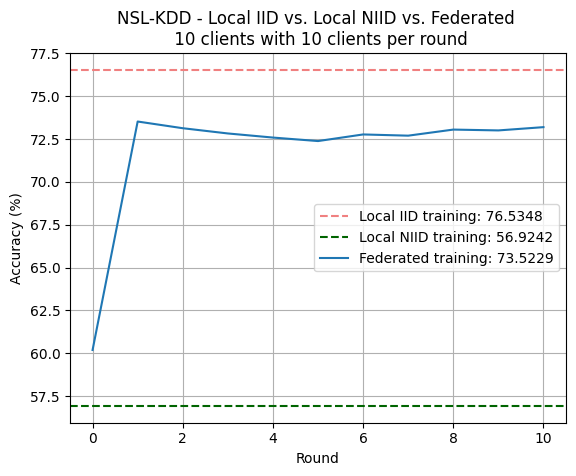

In [41]:
print(f"{history.metrics_centralized = }")

global_accuracy_centralised = cast(list, history.metrics_centralized["accuracy"])
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]

iid = score_iid["accuracy"] * 100
plt.axhline(
    y=iid, label=f"Local IID training: {iid:.4f}", linestyle="--", color="lightcoral"
)
niid = score_niid["accuracy"] * 100
plt.axhline(
    y=niid, label=f"Local NIID training: {niid:.4f}", linestyle="--", color="darkgreen"
)
plt.plot(round, acc, label=f"Federated training: {max(acc):.4f}")
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.legend()
plt.title(
    "NSL-KDD - Local IID vs. Local NIID vs. Federated \n 10 clients with 10 clients per"
    " round"
)